In [1]:
from datetime import datetime

import torch
import numpy as np


import util, tr_util
from my_gcn import GCN
from Dimploma.EnvironmentTree import EnvMinimalTreeTwoStep
from Dimploma.ppo_parallel_custom import Agent, test_random
from Dimploma.utils.graph_provider import GraphProvider

In [2]:
%load_ext autoreload
%autoreload 2

In [25]:
node_amount = 10
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = int(max_edge_amount*0.8)
iteration_amount = 1000
epoch_amount = 10
batch_size = 64
node_features = 2  # (index, {0,1} selected or not)
steps_amount = int((node_amount - 1)*2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)
early_stop = True
position = True
remove_index = True
if position:
    node_features += 2

cat_in_net = True
conv_layers = 6
conv_p_layers = 2
linear_layers = 2


gamma=0.99
epsilon=0.3
coef_value=0.5
coef_entropy=0.001
gae_lambda=0.95
lr=0.00025


fixed_graph = False
# load_graph = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/graph.pt'
# load_graph = 'graphs/graph2_norm.pt'
# load_graph = 'graphs/graph5_n50_norm.pt'
# load_graph = 'graphs/graph8_n10_e36_pos.pt'
load_graph = ''
save_new = ''
# save_new = f'graphs/graph8_n{node_amount}_e{edge_amount}_pos.pt'
# load_from = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/models/iter_499_last.pt'
# load_from = 'results/min_tree_ppo/node/250103_18#n10_e45_not_fixed/models/iter_999_last.pt'
load_from = ''
graph = None

if load_graph != '':
    print('Loading graph')
    graph = torch.load(load_graph)
    util.show_data(graph)
elif fixed_graph:
    print('Fixing graph')
    graph = util.generate_random_graph_add_method(node_amount, edge_amount, device=device, position=position)
    if save_new != '':
        print('Saving graph')
        torch.save(graph, save_new)
    util.show_data(graph)

graph_provider = GraphProvider(fixed_graph=graph, device=device, nodes=node_amount, edges=edge_amount, position=position)


name = f'n{node_amount}_e{edge_amount}_pos_notfixed'

training_desc = f'''
Added positions to nodes and calculated the distance between them
Not fixed graphs
trying out training with:
fixed graph

Training
Iterations: {iteration_amount}
Epochs: {epoch_amount}
Batch size: {batch_size}
Steps amount: {steps_amount}
On device: {device}
{'with' if early_stop else 'without'} early stopping


Network:
{conv_layers}-{conv_p_layers} GAT layers
{linear_layers} linear layers
{'with' if cat_in_net else 'without'} catenation between layers

Graphs:
{f'Loaded graph from {load_graph}' if load_graph != '' else 'Fixed graph' + {f' saved  as {save_new}' if save_new != '' else ''} if fixed_graph else f'Random generated graphs'}
Node amount: {node_amount}
Edge amount: {edge_amount}
Node features: {node_features}
{'Without indexes in nodes' if remove_index else 'With indexes in nodes'}
{'With positions' if position else ''}

Parameters:
Gamma: {gamma}
Epsilon: {epsilon}
Coef_value: {coef_value}
Coef_Entropy: {coef_entropy}
Gae_lambda: {gae_lambda}
Learning rate: {lr}
'''

path = 'results/min_tree_ppo/node/'
last_path = f'models/iter_{iteration_amount - 1}_last.pt'
print("Name:", name)
if fixed_graph:
    print(graph.edge_index, '\n', graph.edge_attr, '\n', graph.x)

device:  cpu
Name: n10_e36_pos_notfixed


In [26]:
last_name = "fuckup"

In [27]:
start_date = datetime.now()

try:
    # noinspection PyUnresolvedReferences
    if last_name == name:
        raise Exception("You should change the name :D")
except NameError:
    raise Exception("You should init last name :D")

if training_desc == '':
    raise Exception("You should write a nice description :D")

last_name = name

net = GCN(node_amount, node_features, cat_in_net, conv_layers, conv_p_layers, linear_layers, remove_index=remove_index)

print(f'Agent {name}')

agent = Agent(model=net, gamma=gamma, epsilon=epsilon, coef_value=coef_value, coef_entropy=coef_entropy, gae_lambda=gae_lambda, lr=lr, device=device, path=path, name=name, override=True, early_stop=early_stop)
# agent = Agent(model=net, device=device, path=path, name=name, override=True)

if load_from != '':
    agent.load_model(load_from)

agent.training_description(training_desc)
training_desc = ''
# agent.train([device, None, node_amount, edge_amount], EnvMinimalTreeTwoStep, node_amount, count_of_processes=1, count_of_envs=1, batch_size=32, count_of_iterations=iteration_amount)
agent.train([graph_provider], EnvMinimalTreeTwoStep, node_amount, count_of_iterations=iteration_amount, count_of_epochs=epoch_amount, batch_size=batch_size, count_of_steps=steps_amount)


end_date = datetime.now()
torch.save(graph, agent.path + '/graph.pt')
s = (end_date - start_date).seconds
hours, remainder = divmod(s, 3600)
minutes, seconds = divmod(remainder, 60)
#-1.42077
print(f'Time training {int(hours):02}:{int(minutes):02}:{int(seconds):02}')

Agent n10_e36_pos_notfixed
Training is starting
Iteration 0 starting
Iteration 0	episode 32	avg score -0.04492	best score 0.44317	best avg score -0.04492
Writing to early val: -0.044917123339412564
Iteration 1 starting
Iteration 1	episode 64	avg score -0.11005	best score 0.44317	best avg score -0.04492
Iteration 2 starting
Iteration 2	episode 96	avg score -0.12083	best score 0.61587	best avg score -0.04492
Iteration 3 starting
Iteration 3	episode 128	avg score -0.12727	best score 0.61587	best avg score -0.04492
Iteration 4 starting
Iteration 4	episode 160	avg score -0.08099	best score 0.62162	best avg score -0.04492
Iteration 5 starting
Iteration 5	episode 192	avg score -0.09286	best score 0.62162	best avg score -0.04492
Iteration 6 starting
Iteration 6	episode 224	avg score -0.11379	best score 0.62162	best avg score -0.04492
Iteration 7 starting
Iteration 7	episode 256	avg score -0.16442	best score 0.62162	best avg score -0.04492
Iteration 8 starting
Iteration 8	episode 288	avg score 

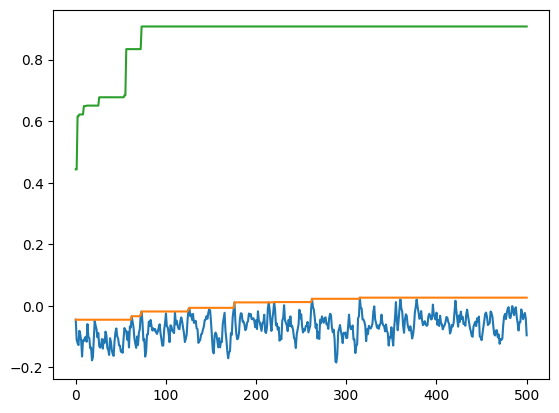

AttributeError: 'NoneType' object has no attribute 'node_offsets'

In [28]:
loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing(agent.path, iteration_amount, graph_provider, GCN(node_amount, node_features, cat_in_net, conv_layers, conv_p_layers, linear_layers), device)

In [29]:
# Testing
test_amount = 100
objs_test = np.zeros(test_amount, dtype=np.float32)
rews_test = np.zeros(test_amount, dtype=np.float32)
actions_test = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

objs_test_r = np.zeros(test_amount, dtype=np.float32)
rews_test_r = np.zeros(test_amount, dtype=np.float32)
actions_test_r = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

for i in range(test_amount):
    obj, sel, rew, acts = agent_test.test(test_env)
    objs_test[i] = obj
    rews_test[i] = rew[-1]
    actions_test[i, :len(acts)] = acts
    
    obj_r, sel_r, rew_r, acts_r  = test_random(test_env)
    objs_test_r[i] = obj_r
    rews_test_r[i] = rew_r[-1]
    actions_test_r[i, :len(acts_r)] = acts_r
    # print(sel)

print("Objs")
print(f'Mean: {objs_test.mean():.2f}')
print(f'Min: {objs_test.min()}')
print(f'Max: {objs_test.max()}')
print("Random")
print(f'Mean: {objs_test_r.mean():.2f}')
print(f'Min: {objs_test_r.min()}')
print(f'Max: {objs_test_r.max()}')

Objs
Mean: 68.22
Min: 64.32459259033203
Max: 78.96818542480469
Random
Mean: 89.15
Min: 67.87516784667969
Max: 113.02629852294922


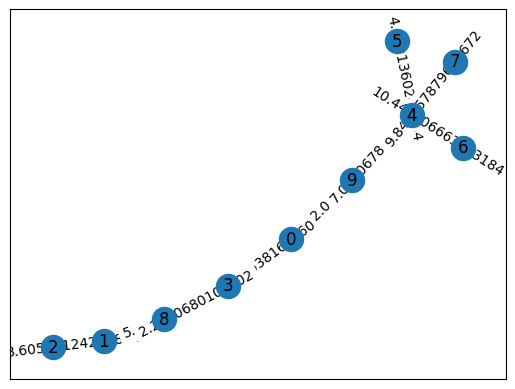

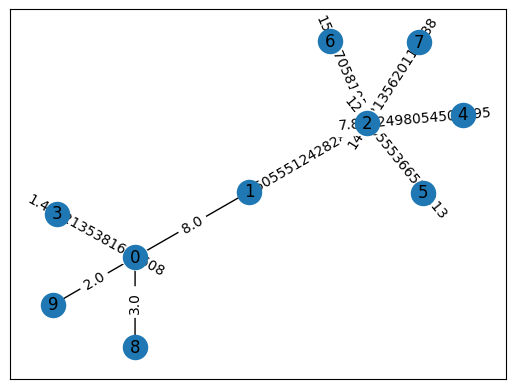

(tensor([1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.]),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5359429009681216],
 [2, 1, 2, 7, 0, 3, 0, 8, 2, 5, 0, 1, 0, 9, 2, 6, 2, 4])

In [30]:
_ ,a, b, c = agent_test.test(test_env)
util.show_data(test_env.min_tree)
test_env.show_selected_tree()

# mask = torch.argwhere(graph_test.edge_attr[:, 1] == 1)[:, 0]
# sel_graph = Data(x=graph_test.x, edge_index=graph_test.edge_index[:, mask], edge_weight=graph_test.edge_weight[mask])
# sel_graph_g = util.my_to_networkx(sel_graph)
# util.show_data(sel_graph)
a,b,c

In [31]:
util.get_node_sums(test_env.graph)

tensor([[9.0000, 0.0000, 5.0000, 4.0000, 8.0000, 3.0000, 1.0000, 6.0000, 2.0000,
         7.0000],
        [2.4750, 2.7446, 2.8394, 3.2870, 3.3229, 3.3293, 3.9818, 4.1304, 4.2939,
         6.2926]])

In [32]:
util.get_out_edges(test_env.graph)

tensor([[6., 5., 0., 3., 9., 1., 2., 4., 7., 8.],
        [5., 6., 7., 7., 7., 8., 8., 8., 8., 8.]])